# FAI Homework 5

**FBA Quant 이의형**

---

## Problem 1. Empirical Research for EF, CML, and CAPM

---

**(a)** Draw an efficient frontier and capital market line using 30 stocks daily close price data.  
(You get the close price data by using our homework 2. The KRX database crawler.)  
Assume risk free rate is 1%.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from krx import WebSource

np.random.seed(28)

def filter_period_cond(universe, start, end):
    stocks = []
    start_list = kw.get_stocks_in_index('KOSPI', start)
    end_list = kw.get_stocks_in_index('KOSPI', end)
    for start_stock in start_list:
        if start_stock in end_list:
            stocks.append(start_stock)
    return np.array(stocks)

In [2]:
kw = WebSource()
kw.set_freq(0.1)

start = '2020-09-01'
end = '2023-08-31'
num = 30

universe = kw.get_stocks_in_index('KOSPI', date=end)
stock_list = filter_period_cond(universe, start, end)
rand_idx = np.random.randint(0, len(stock_list), num)
stocks_30 = np.array(stock_list)[rand_idx]
stocks_30

Set freq: 0.1


array(['A034830', 'A005430', 'A002390', 'A019170', 'A042700', 'A039490',
       'A012450', 'A020000', 'A129260', 'A015890', 'A071970', 'A001740',
       'A000220', 'A017180', 'A012800', 'A012030', 'A009310', 'A092200',
       'A001460', 'A000020', 'A271560', 'A011070', 'A014910', 'A024900',
       'A014820', 'A007120', 'A002690', 'A074610', 'A000680', 'A004490'],
      dtype='<U7')

In [3]:
%%time
index = kw.get_daily_stock_info('A005930', start, end).index
adj_close = pd.DataFrame(index=index, columns=stocks_30)

for stock in stocks_30:
    adj_close[stock] = kw.get_daily_stock_info(stock, start, end).adj_close
    
adj_close

Wall time: 59.5 s


,A034830,A005430,A002390,A019170,A042700,A039490,A012450,A020000,A129260,A015890,...,A271560,A011070,A014910,A024900,A014820,A007120,A002690,A074610,A000680,A004490
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,1730,30250,38750,147000,5125,112000,26700,31300,2950,5070,...,139500,153500,1600,1920,21950,1835,1873,4685,2040,27900
2020-09-02,1870,30750,38850,158000,5150,117500,26800,31800,2865,5090,...,139000,169000,1880,1970,22400,1835,1869,4700,2080,28750
2020-09-03,1830,31100,38850,156500,5350,116000,29250,32150,2830,5050,...,137000,163000,1930,1945,22400,1865,1937,4760,2110,28900
2020-09-04,1855,30800,37850,146000,5250,114000,29150,31300,2830,5000,...,135000,158000,1975,1880,21850,1815,2034,4615,2100,28150
2020-09-07,1895,31250,38050,148500,5250,114000,28800,31100,2830,5150,...,135000,158500,2080,1965,22000,1805,2056,4765,2215,28750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-25,1235,41900,13370,17170,54400,98900,110000,18180,2395,8210,...,125500,254500,1684,5610,33800,1362,1815,6800,5020,50100
2023-08-28,1238,42200,13380,17200,55000,101200,113100,18590,2410,8460,...,124700,257000,1707,5790,34550,1405,1833,7450,4900,50200
2023-08-29,1239,41700,13320,17550,55300,102300,113300,18610,2410,8130,...,122300,264500,1716,5980,34800,1415,1856,7180,4830,55000


In [4]:
rtn_1d = adj_close.pct_change(1, axis=0)
rtn_1d = rtn_1d.iloc[1:,:]
annual_rtn = rtn_1d.mean(axis=0) * 252
annual_cov = rtn_1d.cov() * 252

port_rtn = []
port_std = []
port_weights = []

In [5]:
def calculate_portfolio_var(weights, annual_cov):
    return np.dot(weights.T, np.dot(annual_cov, weights))

initial_weights = np.array([ 1/rtn_1d.shape[1] for _ in range(rtn_1d.shape[1]) ])
bounds = [(-1, 1)] * rtn_1d.shape[1]

for target_rtn in np.linspace(0.01, 3, 100):
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, annual_rtn) - target_rtn}
    ]
    result = minimize(
        calculate_portfolio_var,
        initial_weights,
        args=annual_cov,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    if result.success:
        port_rtn.append(target_rtn)
        port_std.append(np.sqrt(result.fun))
        port_weights.append(result.x)

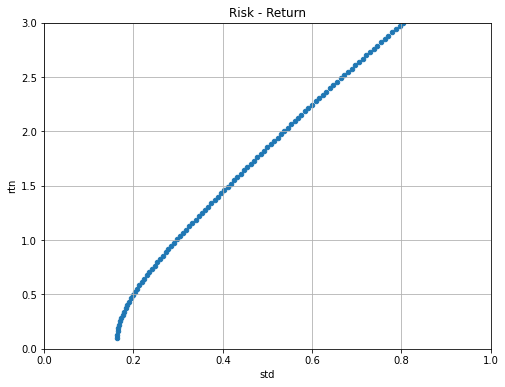

In [6]:
rf = 0.01
pf = pd.DataFrame({'rtn': port_rtn, 'std': port_std, 'weight': port_weights})
pf['sharpe'] = ((pf['rtn'] - rf) / pf['std'])

minvar_idx = pf['std'].idxmin()
minvar_rtn = pf.loc[minvar_idx, 'rtn']
eff_pf = pf[pf['rtn'] > minvar_rtn]

eff_pf.plot(kind = 'scatter', figsize = (8,6), xlim=(0, 1), ylim=(0, 3),
        title = 'Risk - Return', x = 'std', y = 'rtn', grid=True);

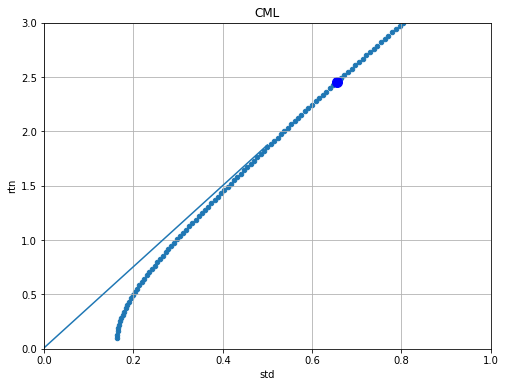

In [7]:
max_sharpe_pf = eff_pf.loc[pf['sharpe'].idxmax(),:]
max_sharpe = max_sharpe_pf.sharpe

x = np.array([-0, 0.5])
y = rf + x * max_sharpe
cml = pd.Series(index = x, data=y)

eff_pf.plot(kind='scatter', figsize=(8,6), x='std', y='rtn', grid=True);
cml.plot(kind='line', xlim=(0, 1), ylim=(0, 3), grid=True);
plt.scatter(max_sharpe_pf['std'], max_sharpe_pf['rtn'], c='b', marker='o', s=100)
plt.title('CML');

---

**(b)** Calculate CAPM alpha for each stock.  
Do you think that the alpha will last in the future? If so, why? If not so, why?

In [8]:
mvp_idx = eff_pf['sharpe'].idxmax()
mk = eff_pf.loc[mvp_idx,:]
mk_weight = mk['weight']

mk_rtn_1d = rtn_1d @ mk_weight
mk_rtn = mk_rtn_1d.mean() * 252
mk_var = mk_rtn_1d.var() * 252

stock_rtn = rtn_1d.mean(axis=0) * 252

beta = pd.Series(index=stocks_30, dtype=np.float64)
for stock in beta.index:
    mk_stock_cov = mk_rtn_1d.cov(rtn_1d[stock]) * 252
    beta.loc[stock] = mk_stock_cov / mk_var
beta

A034830    0.000141
A005430    0.099867
A002390   -0.066422
A019170   -0.132587
A042700    0.433820
A039490    0.048657
A012450    0.276614
A020000   -0.014010
A129260    0.054998
A015890    0.141302
A071970    0.315272
A001740    0.096521
A000220   -0.007212
A017180   -0.072254
A012800    0.169937
A012030    0.209937
A009310   -0.050122
A092200    0.292448
A001460    0.134906
A000020   -0.047468
A271560    0.032428
A011070    0.145649
A014910    0.092867
A024900    0.263315
A014820    0.146766
A007120    0.066554
A002690    0.084917
A074610    0.219669
A000680    0.233884
A004490    0.194435
dtype: float64

In [9]:
mk_rp = mk_rtn - rf
expected_stock_rtn = rf + beta*mk_rp
alpha = stock_rtn - expected_stock_rtn
alpha

A034830   -0.087145
A005430   -0.087372
A002390   -0.173436
A019170   -0.086495
A042700   -0.086469
A039490   -0.087166
A012450   -0.087416
A020000   -0.087849
A129260   -0.087055
A015890   -0.087048
A071970   -0.087183
A001740   -0.087121
A000220   -0.087663
A017180   -0.087619
A012800   -0.086996
A012030   -0.086860
A009310   -0.087183
A092200   -0.087264
A001460   -0.086763
A000020   -0.087507
A271560   -0.087484
A011070   -0.087090
A014910   -0.087306
A024900   -0.087038
A014820   -0.087017
A007120   -0.087421
A002690   -0.087362
A074610   -0.087252
A000680   -0.086944
A004490   -0.087067
dtype: float64

**결과의 이유**  

베타가 특이하게 작고, 전부 마이너스 알파를 나타내고 있다.  

먼저 이러한 결과가 나오는 이유에 대해 생각해보면, 과거 확정 수익률로 진행한 분석은 IS 최적화와 유사한 프로세스가 될 수밖에 없다.  

최적화 된 포트폴리오는 실제로 해당 기간 최대의 Sharpe를 얻는 포트폴리오이다. (공매도까지 허용하기 때문에 더욱 심화)  

이 포트폴리오를 시장 포트폴리오로 설정한다면, 개별종목은 시장을 따라가지 못한다. 즉, 시장의 초과 변동(beta > 1)은 불가능할 것이다.

따라서 베타의 절대값도 상당히 적어지게 된다.


**알파 지속 여부**  

이와 별개로 이론적인 가정에서 알파는 지속되지 못할 것이다.  

알파가 존재한다는 것을 알게 된 투자자들은 양의 알파 종목의 비중을 늘리고, 음의 알파 종목의 비중을 줄이며 시장 포트폴리오를 수정할 것이다.

---

## Problem 2. 

---

**(a)** Find about the 'Two Fund Theorem' and prove it mathematically.

**Two Fund Theorem**  

Efficient Frontier의 모든 포트폴리오는 Efficient Frontier의 2개 개별 투자 포트폴리오 $w_1$과 $w_2$ 사이의 자산 배분을 통해 구축될 수 있다.

Efficient Frnotier의 포트폴리오는 아래 조건을 만족한다.  

$$1: \sum_{j=1}^n \sigma_{ij} w_j - \lambda \bar r_i - \mu = 0 \quad \text {for}\;\; i = 1,2,...,n$$

$$2: \sum_{i=1}^n w_i \bar r_i = \bar r$$  

$$3: \sum_{i=1}^n w_i = 1$$  

Efficient Frnotier의 두 포트폴리오를 각각 $w_1, w_2$라 할 때, 두 포트폴리오의 조합을 $\alpha w_1 + (1 - \alpha) w_2$라 할 수 있다.  

두 포트폴리오는 모두 각 수익률에 대한 최소 분산 포트폴리오이므로 최적의 해(두 포트폴리오 모두 해당 식이 0)로써 1번 식을 만족한다.  

$\alpha w_1 + (1 - \alpha) w_2$의 수익률은 $\alpha \bar r_1 + (1 - \alpha) \bar r_2$이므로 
임의의 수익률 $\bar r$를 만들 수 있기 때문에 2번 식을 만족한다.

$w_1, w_2$는 모두 합이 1인 포트폴리오이므로 $\alpha w_1 + (1 - \alpha) w_2$ 역시 1이 되어 3번 식을 만족한다.  

따라서 $\alpha w_1 + (1 - \alpha) w_2$로 만들어진 포트폴리오 또한 Efficient Frnotier의 포트폴리오이다.

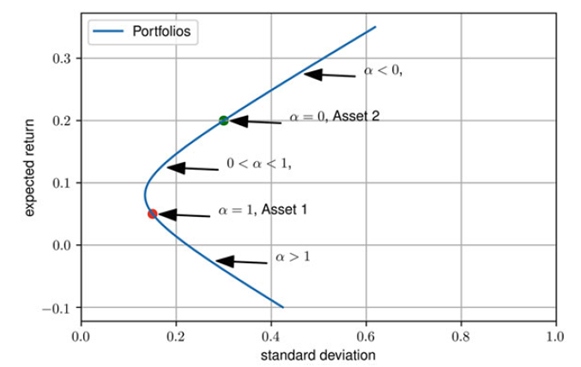

---

**(b)** Write a python code that draws the efficient frontier with given two assets.

In [10]:
rtn_1d = adj_close.pct_change(1, axis=0)  # .iloc[:,:4]
rtn_1d = rtn_1d.iloc[1:,:]

annual_rtn = rtn_1d.mean(axis=0) * 252
annual_cov = rtn_1d.cov() * 252

inv_cov = np.linalg.inv(annual_cov)
v1 = np.ones(annual_rtn.shape[0]) @ inv_cov
w1 = v1 / np.sum(v1)

r = np.array(annual_rtn)
v2 = r @ inv_cov
w2 = v2 / np.sum(v2)

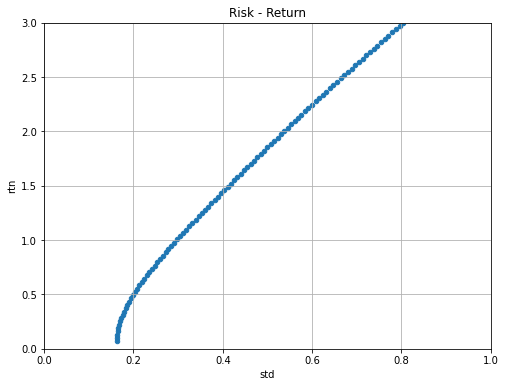

In [11]:
port_rtn = []
port_std = []
port_weights = []
port_alpha = []

for a in range(-200,201):
    a /= 100
    weights = a * w1 + (1-a) * w2

    temp_rtn = np.dot(weights, annual_rtn) 
    temp_std = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))

    port_rtn.append(temp_rtn)
    port_std.append(temp_std)
    port_weights.append(weights)
    port_alpha.append(a)
    
twofund_pf = pd.DataFrame({'rtn': port_rtn, 'std': port_std, 'weight': port_weights, 'alpha': port_alpha})

minvar_idx = twofund_pf['std'].idxmin()
minvar_rtn = twofund_pf.loc[minvar_idx, 'rtn']
eff_twofund_pf = pf[pf['rtn'] > minvar_rtn]

eff_twofund_pf.plot(kind = 'scatter', figsize = (8,6), xlim=(0, 1), ylim=(0, 3),
        title = 'Risk - Return', x = 'std', y = 'rtn', grid=True);

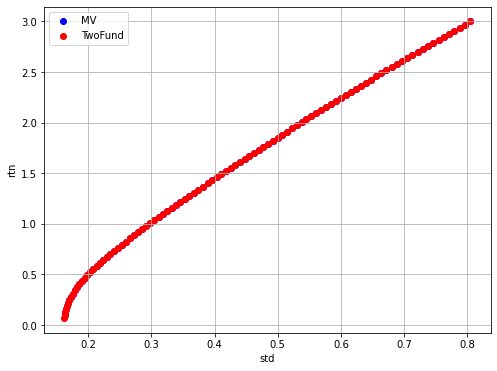

In [12]:
plt.figure(figsize=(8, 6))

plt.scatter(eff_pf['std'], eff_pf['rtn'], label='MV', color='b')
plt.scatter(eff_twofund_pf['std'], eff_twofund_pf['rtn'], label='TwoFund', color='r')

plt.xlabel('std')
plt.ylabel('rtn')

plt.legend()
plt.grid(True)

plt.show()

---